In [11]:
# 1. Instalar kaggle (solo la primera vez)
!pip install -q kaggle

# 2. Subir tu kaggle.json (descárgalo desde https://kaggle.com → Account → Create New API Token)
from google.colab import files
files.upload()  # ← sube aquí tu kaggle.json

# 3. Configurar kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Descargar el dataset directamente
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python
!unzip -q customer-segmentation-tutorial-in-python.zip

Saving Mall_Customers.csv to Mall_Customers (1).csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open customer-segmentation-tutorial-in-python.zip, customer-segmentation-tutorial

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
df.head()

# Usaremos solo las columnas numéricas más interesantes
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Renombramos para que sea más fácil
X.columns = ['Edad', 'Ingresos', 'Gasto']

# Estandarización (¡OBLIGATORIA!)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Para visualización 2D/3D
X_2d = X.copy()

K-MEANS


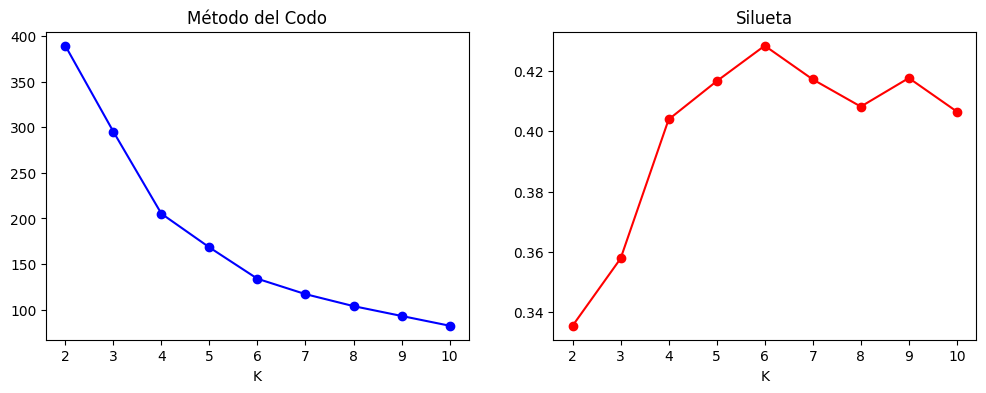

Silueta K-Means: 0.417


In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
import warnings; warnings.filterwarnings('ignore')

# Reducción a 2D para todos los gráficos
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

results = {}

# ==================== K-MEANS ====================
print("K-MEANS")
inertias = []
siluetas = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    siluetas.append(silhouette_score(X_scaled, labels))

# Gráfico del codo
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(range(2,11), inertias, 'bo-'); plt.title('Método del Codo'); plt.xlabel('K')
plt.subplot(1,2,2); plt.plot(range(2,11), siluetas, 'ro-'); plt.title('Silueta'); plt.xlabel('K')
plt.show()

# Elegimos K=5 o K=6 (normalmente el óptimo en este dataset es 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
results['K-Means'] = labels_km
print(f"Silueta K-Means: {silhouette_score(X_scaled, labels_km):.3f}")


JERÁRQUICO


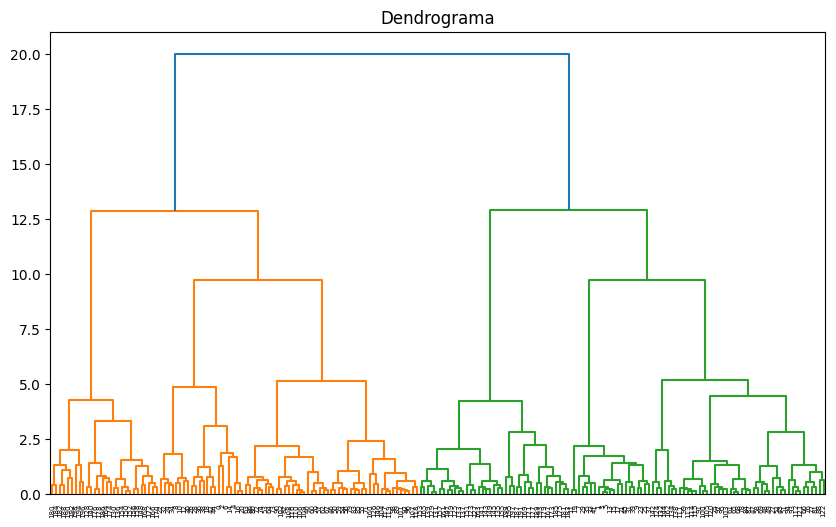

Silueta Jerárquico: 0.390


In [14]:
# ==================== JERÁRQUICO ====================
print("\nJERÁRQUICO")
plt.figure(figsize=(10,6))
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.title('Dendrograma')
plt.show()

# Cortamos en 5 clústeres (mismo número que K-Means para comparar)
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
labels_hc = hc.fit_predict(X_scaled)
results['Jerárquico'] = labels_hc
print(f"Silueta Jerárquico: {silhouette_score(X_scaled, labels_hc):.3f}")


DBSCAN


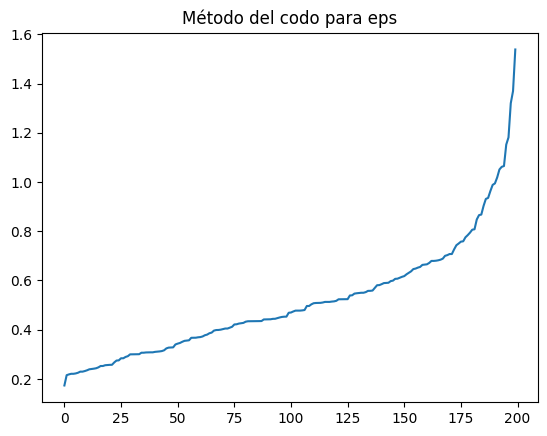

Ruido detectado: 28 puntos
Silueta DBSCAN: 0.273


In [15]:
# ==================== DBSCAN ====================
print("\nDBSCAN")
# Buscamos eps óptimo rápido
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4], axis=0)
plt.plot(distances); plt.title('Método del codo para eps'); plt.show()

# En este dataset eps ≈ 0.5–0.65 suele funcionar bien
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)
results['DBSCAN'] = labels_db

n_noise = list(labels_db).count(-1)
print(f"Ruido detectado: {n_noise} puntos")
if len(set(labels_db)) > 1 and n_noise < len(X)-1:
    print(f"Silueta DBSCAN: {silhouette_score(X_scaled[labels_db!=-1], labels_db[labels_db!=-1]):.3f}")
else:
    print("DBSCAN marcó casi todo como ruido o un solo clúster → silueta no aplicable")

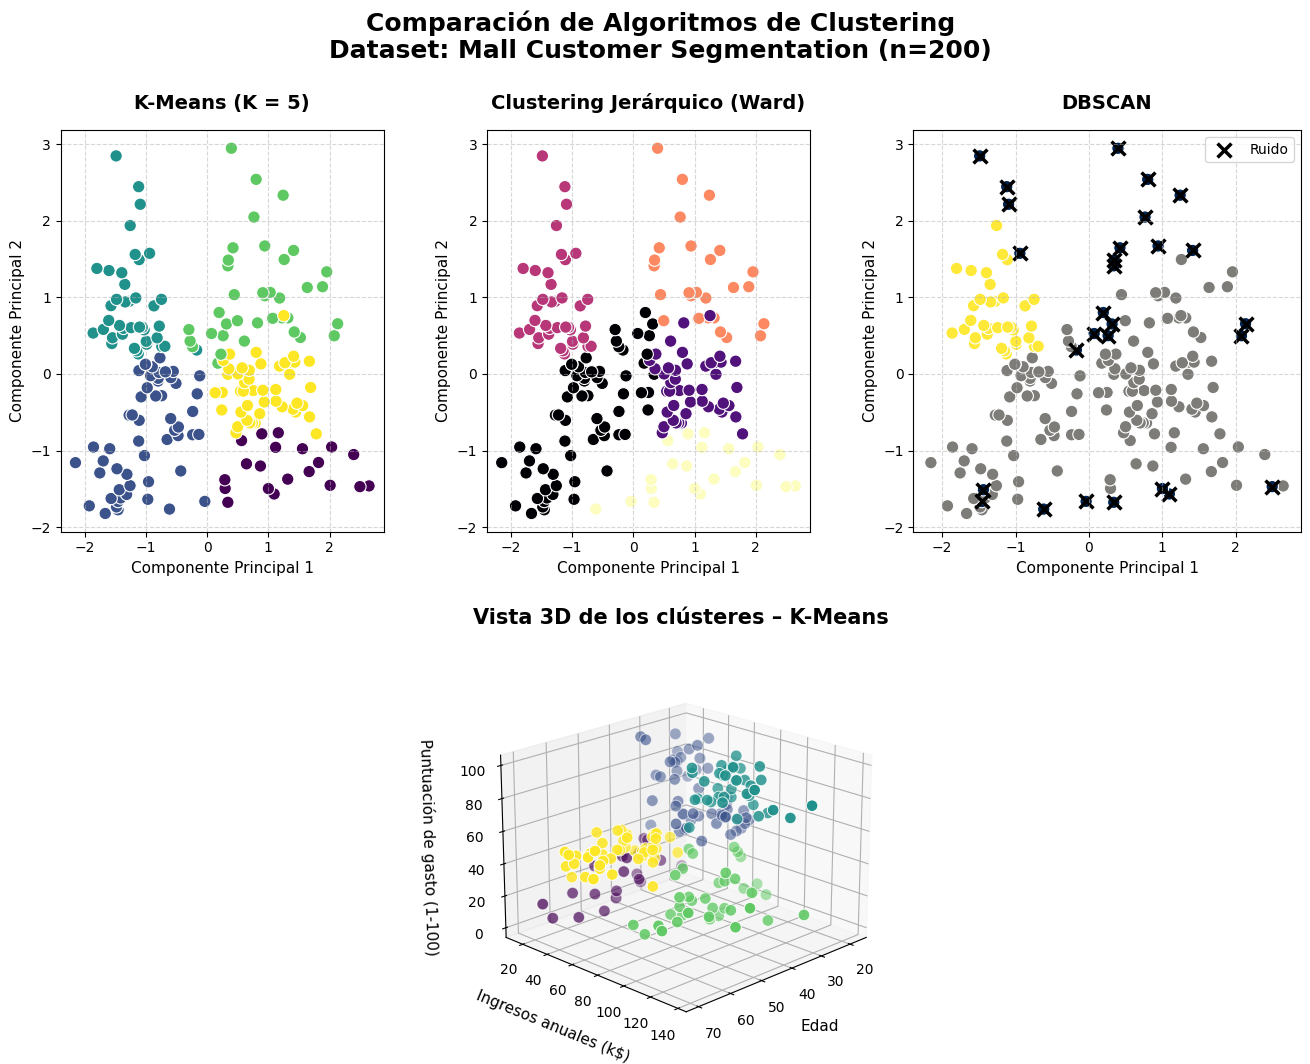

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Paletas profesionales y coherentes
palette_km = "viridis"
palette_hc = "magma"
palette_db = "cividis"

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1.2], height_ratios=[1, 1], wspace=0.3, hspace=0.3)

# 1. K-Means 2D
ax1 = fig.add_subplot(gs[0, 0])
scatter1 = ax1.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, cmap=palette_km, s=80, edgecolor='white', linewidth=0.8)
ax1.set_title(f'K-Means (K = {optimal_k})', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Componente Principal 1', fontsize=11)
ax1.set_ylabel('Componente Principal 2', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.5)

# 2. Jerárquico 2D
ax2 = fig.add_subplot(gs[0, 1])
scatter2 = ax2.scatter(X_pca[:,0], X_pca[:,1], c=labels_hc, cmap=palette_hc, s=80, edgecolor='white', linewidth=0.8)
ax2.set_title('Clustering Jerárquico (Ward)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Componente Principal 1', fontsize=11)
ax2.set_ylabel('Componente Principal 2', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.5)

# 3. DBSCAN 2D (ruido en gris oscuro)
ax3 = fig.add_subplot(gs[0, 2])
colors_db = ['#2E2E2E' if label == -1 else None for label in labels_db]  # ruido negro
scatter3 = ax3.scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap=palette_db, s=80,
                       edgecolor='white', linewidth=0.8)
# Pintar ruido por encima en negro grande
noise = labels_db == -1
ax3.scatter(X_pca[noise,0], X_pca[noise,1], c='black', s=100, marker='x', linewidth=2.5, label='Ruido')
ax3.set_title('DBSCAN', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Componente Principal 1', fontsize=11)
ax3.set_ylabel('Componente Principal 2', fontsize=11)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend()

# 4. Vista 3D completa (usando las 3 variables originales)
ax4 = fig.add_subplot(gs[1, :], projection='3d')  # ocupa toda la fila inferior
scatter4 = ax4.scatter(X['Edad'], X['Ingresos'], X['Gasto'],
                       c=labels_km, cmap=palette_km, s=70, edgecolor='white', linewidth=0.7, depthshade=True)

ax4.set_xlabel('Edad', fontsize=11, labelpad=10)
ax4.set_ylabel('Ingresos anuales (k$)', fontsize=11, labelpad=10)
ax4.set_zlabel('Puntuación de gasto (1-100)', fontsize=11, labelpad=10)
ax4.set_title('Vista 3D de los clústeres – K-Means', fontsize=15, fontweight='bold', pad=20)

# Mejora ángulo de visión para que se vea perfecto
ax4.view_init(elev=20, azim=45)

# Título general
fig.suptitle('Comparación de Algoritmos de Clustering\nDataset: Mall Customer Segmentation (n=200)',
             fontsize=18, fontweight='bold', y=0.98)

plt.show()

In [25]:
import pandas as pd
import time
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# === CÁLCULO DE TIEMPOS ===
start = time.time()
KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_scaled)
time_km = time.time() - start

start = time.time()
AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward').fit(X_scaled)
time_hc = time.time() - start

start = time.time()
DBSCAN(eps=0.6, min_samples=5).fit(X_scaled)
time_db = time.time() - start

# === SILUETA SEGURA ===
def safe_silhouette(labels):
    unique = np.unique(labels)
    if len(unique) < 2 or len(unique) == len(X_scaled):
        return None
    if -1 in labels:
        mask = labels != -1
        if np.sum(mask) < 2 or len(np.unique(labels[mask])) < 2:
            return None
        return silhouette_score(X_scaled[mask], labels[mask])
    return silhouette_score(X_scaled, labels)

sil_km = silhouette_score(X_scaled, labels_km)
sil_hc = silhouette_score(X_scaled, labels_hc)
sil_db = safe_silhouette(labels_db)

# === DAVIES-BOULDIN SEGURO ===
def safe_db(labels):
    if safe_silhouette(labels) is None:
        return None
    mask = labels != -1 if -1 in labels else slice(None)
    return davies_bouldin_score(X_scaled[mask], labels[mask])

db_km = davies_bouldin_score(X_scaled, labels_km)
db_hc = davies_bouldin_score(X_scaled, labels_hc)
db_db = safe_db(labels_db)

# === NÚMERO DE CLÚSTERES Y RUIDO ===
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)

# === TABLA FINAL (SIN ERRORES) ===
comparacion = pd.DataFrame({
    'Algoritmo': ['K-Means', 'Clustering Jerárquico', 'DBSCAN'],
    'Nº de clústeres': [optimal_k, 5, n_clusters_db if n_clusters_db > 0 else '—'],
    'Puntos ruido': [0, 0, n_noise],
    'Silueta': [sil_km, sil_hc, sil_db],
    'Davies-Bouldin': [db_km, db_hc, db_db],
    'Tiempo (seg)': [round(time_km, 4), round(time_hc, 4), round(time_db, 4)]
})

# Redondeo
comparacion['Silueta'] = comparacion['Silueta'].round(3)
comparacion['Davies-Bouldin'] = comparacion['Davies-Bouldin'].round(3)

# Función de resaltado (CORREGIDA)
def highlight_best(s):
    if s.dtype == 'object':
        return [''] * len(s)
    if s.name == 'Silueta':
        return ['font-weight: bold; color: darkgreen' if v == s.max() else '' for v in s]
    if s.name in ['Davies-Bouldin', 'Tiempo (seg)']:
        return ['font-weight: bold; color: darkgreen' if v == s.min() else '' for v in s]
    return [''] * len(s)

# TABLA BONITA FINAL
(comparacion
 .style
 .apply(highlight_best, axis=0)
 .background_gradient(cmap='Blues', subset=['Silueta'])
 .background_gradient(cmap='Oranges_r', subset=['Davies-Bouldin'])
 .background_gradient(cmap='Greens_r', subset=['Tiempo (seg)'])
 .set_caption('Comparación de Algoritmos de Clustering<br><small>Mall Customer Segmentation Data (n = 200)</small>')
 .set_table_styles([
     {'selector': 'caption', 'props': 'font-size: 17px; font-weight: bold; text-align: center; margin-bottom: 15px;'},
     {'selector': 'th', 'props': 'background-color: #2c3e50; color: white; font-weight: bold; text-align: center;'},
     {'selector': 'td', 'props': 'text-align: center;'}
 ])
 .format({'Silueta': '{:.3f}', 'Davies-Bouldin': '{:.3f}', 'Tiempo (seg)': '{:.4f}'})
)

,Algoritmo,Nº de clústeres,Puntos ruido,Silueta,Davies-Bouldin,Tiempo (seg)
0,K-Means,5,0,0.417,0.875,0.0297
1,Clustering Jerárquico,5,0,0.390,0.916,0.0033
2,DBSCAN,2,28,0.273,1.020,0.0039
